In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/common-heart-disease-data-4-hospitals/heart_disease.csv


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, auc

import warnings
warnings.filterwarnings('ignore')

## 1. Exploratory Data Analysis

In [4]:
# Set visualization style
plt.style.use('seaborn')
%matplotlib inline

In [2]:
# Load the data
df = pd.read_csv('/kaggle/input/common-heart-disease-data-4-hospitals/heart_disease.csv')

# View column basic info
print("\nFirst 5 entries:")
print(df.head())
print("\nColumn Basic Info:")
print(df.info())
print("\nMissing Values in Each Column:")
print(df.isnull().sum())


First 5 entries:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target     source  
0    3.0  0.0   6.0       0  cleveland  
1    2.0  3.0   3.0       1  cleveland  
2    2.0  2.0   7.0       1  cleveland  
3    3.0  0.0   3.0       0  cleveland  
4    1.0  0.0   3.0       0  cleveland  

Column Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    float64
 1   sex       920 non-null    

In [6]:
# Basic dataset overview
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nSummary Statistics:\n", df.describe())

Dataset Shape: (920, 15)

Data Types:
 age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
target        int64
source       object
dtype: object

Summary Statistics:
               age         sex          cp    trestbps        chol         fbs  \
count  920.000000  920.000000  920.000000  920.000000  920.000000  920.000000   
mean    53.510870    0.789130    3.250000  132.268478  199.640870    0.176304   
std      9.424685    0.408148    0.930969   18.569153  109.240114    0.357484   
min     28.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%     47.000000    1.000000    3.000000  120.000000  177.000000    0.000000   
50%     54.000000    1.000000    4.000000  130.000000  223.000000    0.000000   
75%     60.000000    1.000000    4.000000  140.000000  267

In [5]:
# Check for class imbalance in the target variable
print("\nTarget Distribution:\n", df['target'].value_counts(normalize=True))


Target Distribution:
 target
1    0.553261
0    0.446739
Name: proportion, dtype: float64


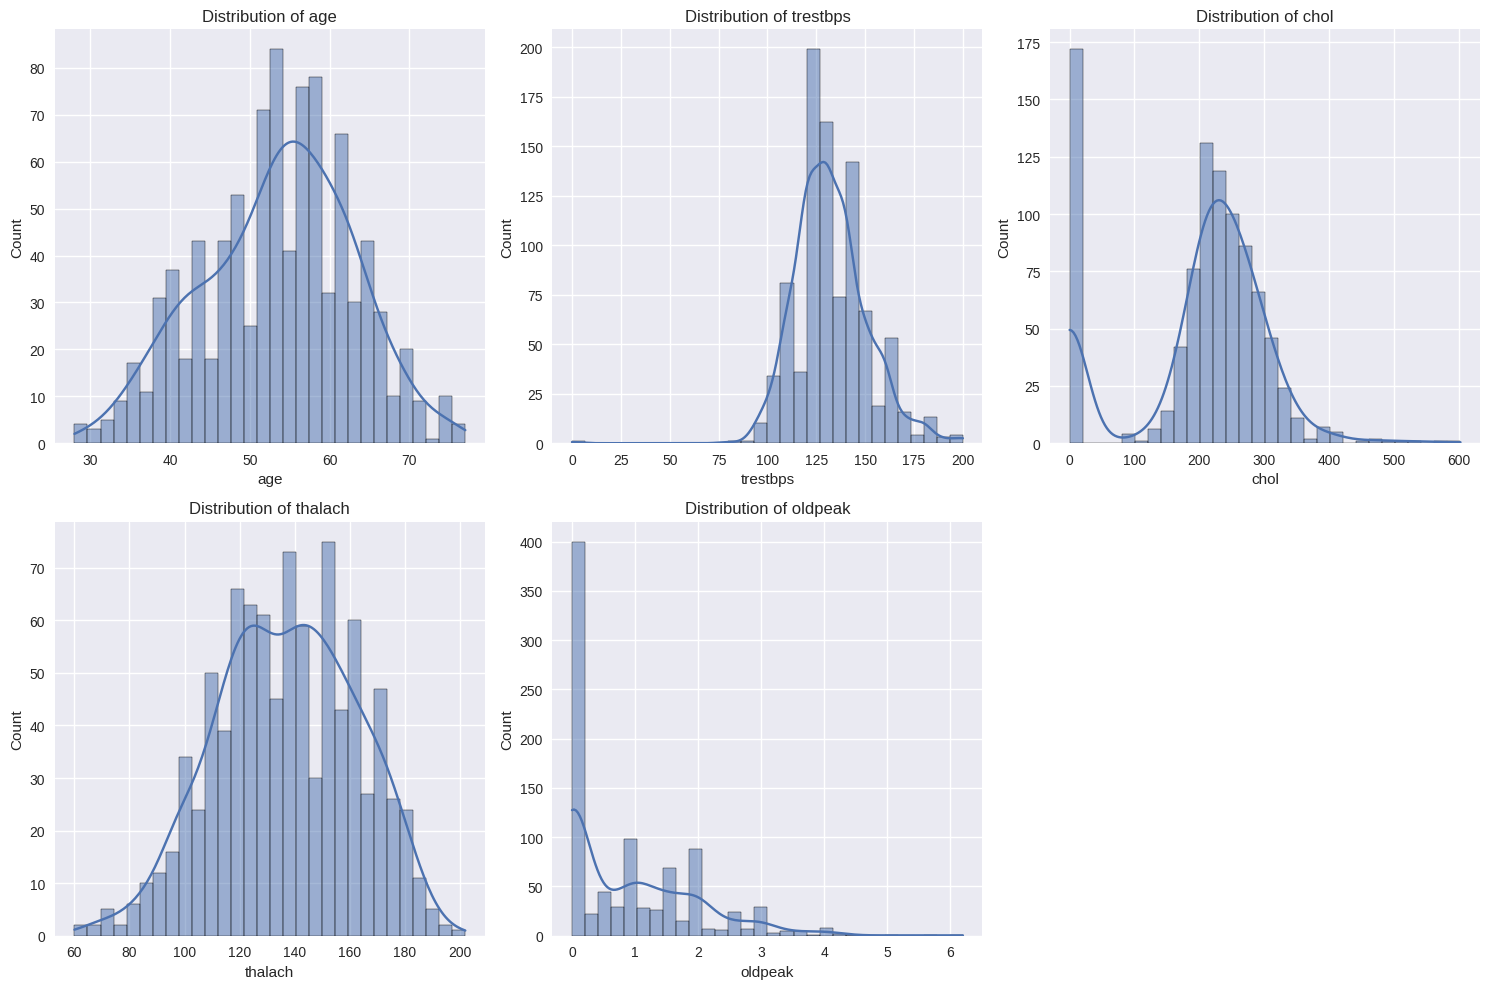

In [7]:
# Visualize distributions of numerical features
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

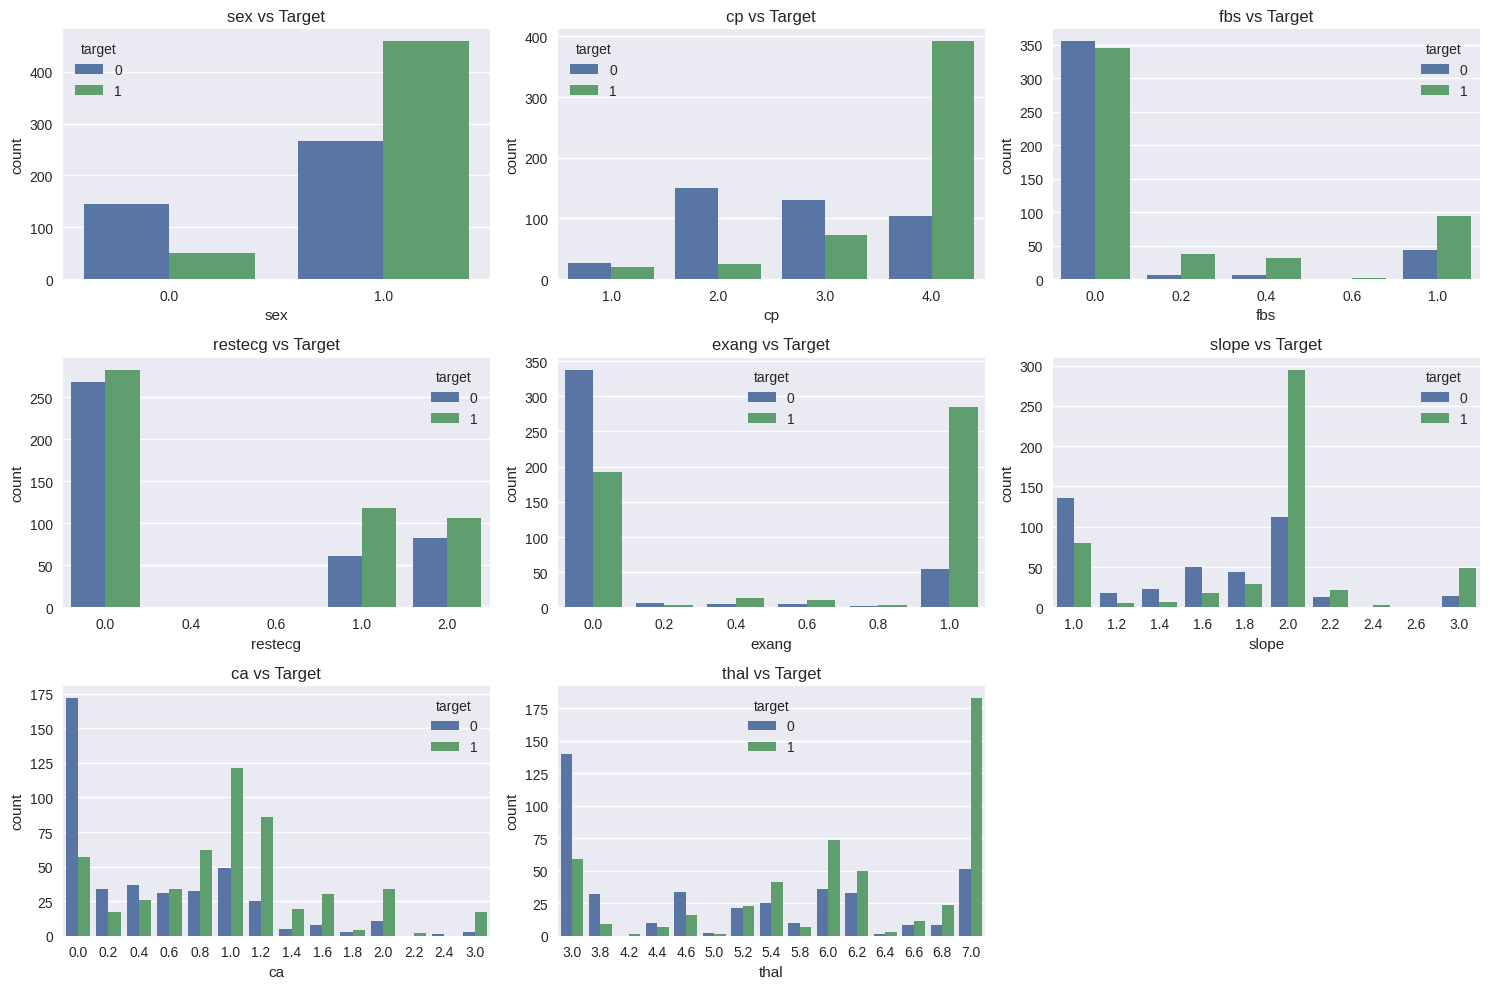

In [8]:
# Visualize categorical features
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, hue='target', data=df)
    plt.title(f'{feature} vs Target')
plt.tight_layout()
plt.show()

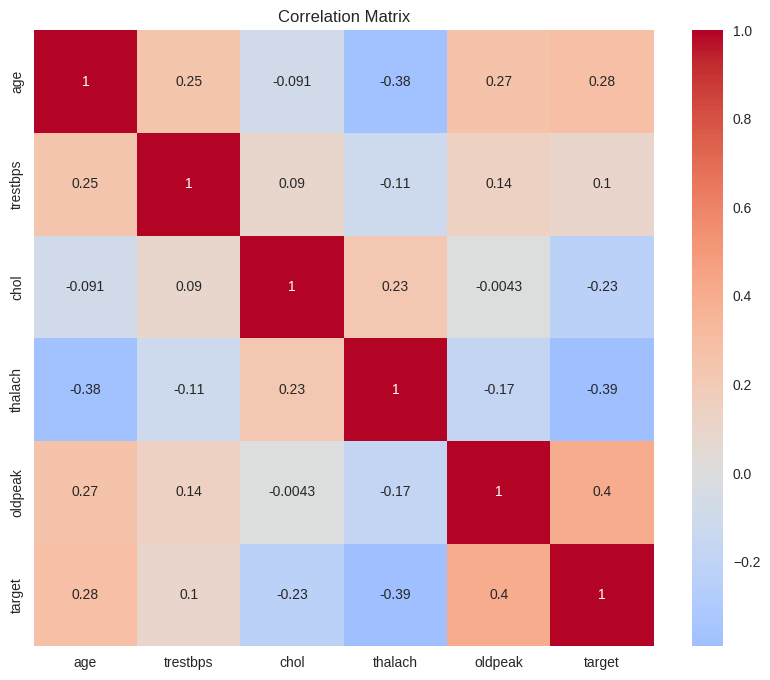

In [9]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features + ['target']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

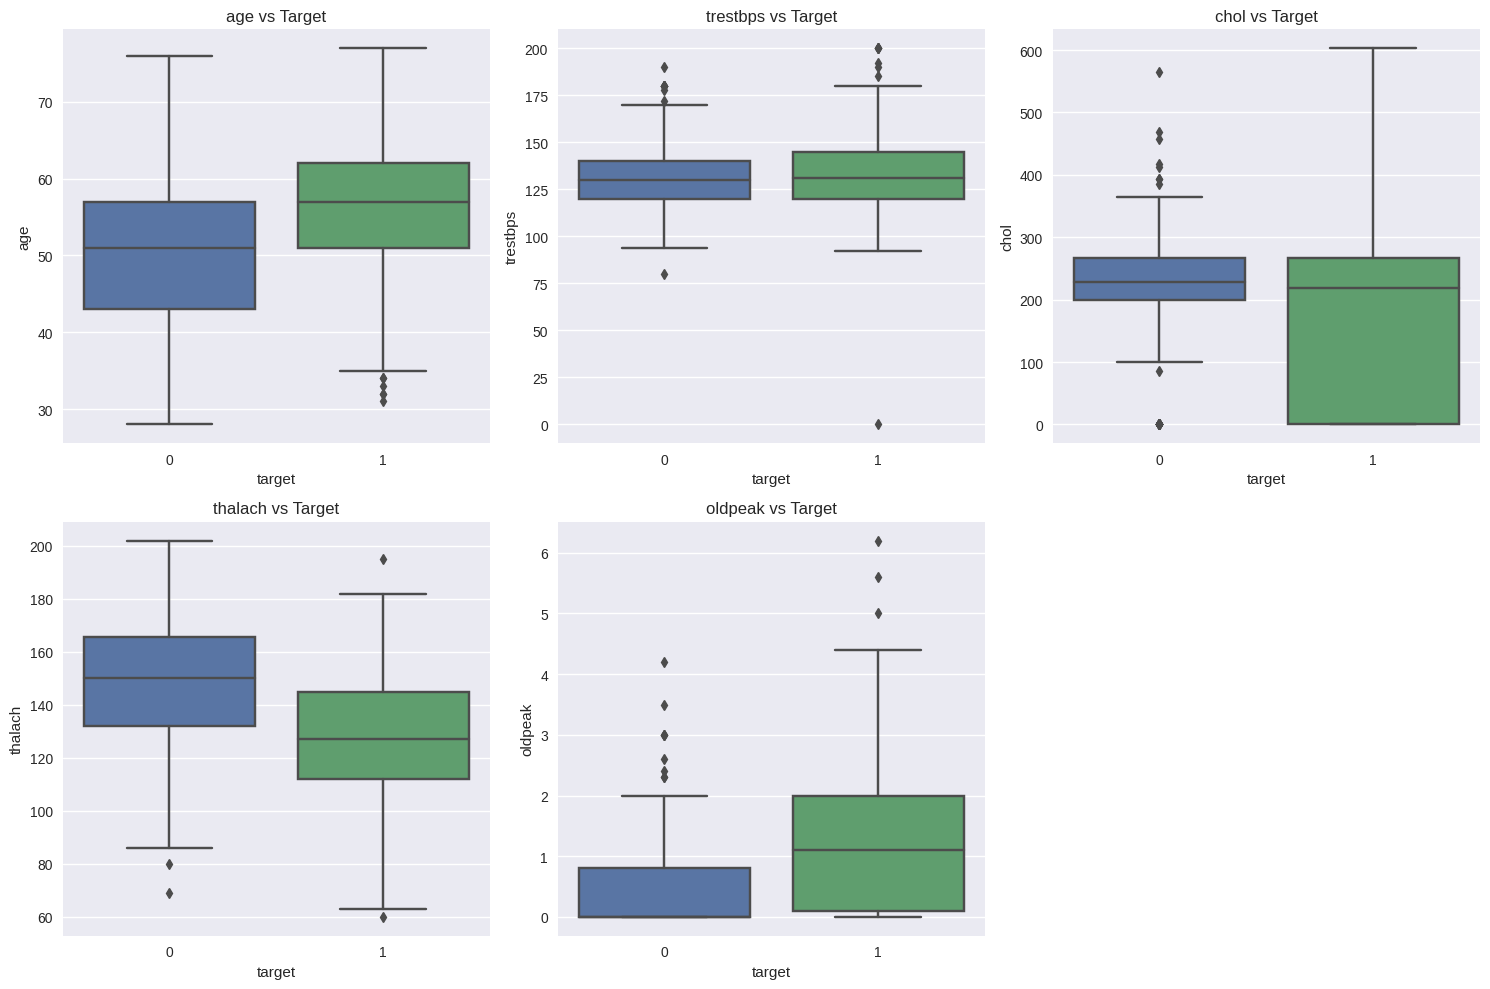

In [10]:
# Boxplots to check for outliers in numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='target', y=feature, data=df)
    plt.title(f'{feature} vs Target')
plt.tight_layout()
plt.show()


Source Distribution:
 source
cleveland        303
hungarian        294
va_long_beach    200
switzerland      123
Name: count, dtype: int64


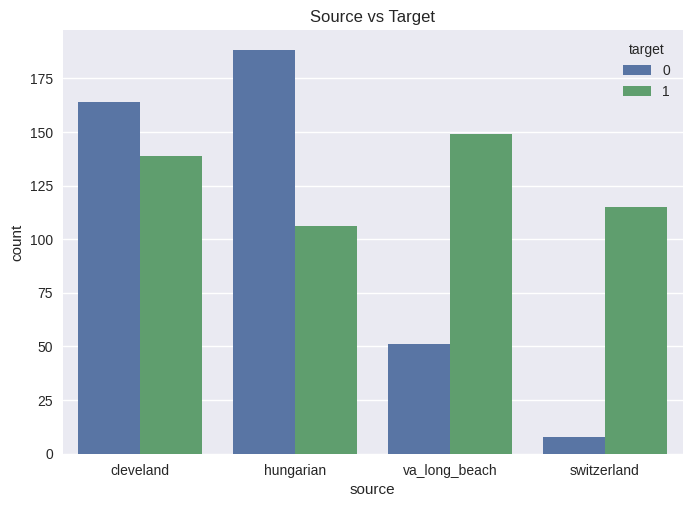

In [11]:
# Source distribution
print("\nSource Distribution:\n", df['source'].value_counts())
sns.countplot(x='source', hue='target', data=df)
plt.title('Source vs Target')
plt.show()

#### **Analysis of Results**

**1. Numerical Feature Distributions:**

- Age, trestbps, chol, and thalach show relatively normal distributions with some skewness, while oldpeak is right-skewed, could signal potential outliers or non-linear relationships with the target.
- Outliers are evident in chol and trestbps, which may require additional handling.
  
**2. Categorical Feature Analysis:**

- Sex shows a strong imbalance, with most patients being male, which may introduce bias unless addressed.
- Cp (chest pain type) and thal (thallium stress test) exhibit varying distributions across target classes.
- Exang (exercise-induced angina) and ca (number of major vessels) show differences between target classes, with higher values potentially correlated with heart disease.
- Slope and restecg also display class-specific patterns, warrants inclusion in feature engineering.
  
**3. Source Distribution:**

- The data originates from four sources, with Cleveland and Hungarian dominating, followed by VA Long Beach and Switzerland. The Switzerland source has a notable skew toward target = 1, which may indicate dataset-specific biases needing stratification during modeling.
  
**4. Correlation Matrix:**

- Moderate positive correlations exist between age and trestbps (0.25), and oldpeak with target (0.28), a sign that these features may be important predictors.
- A strong negative correlation (-0.39) between thalach (max heart rate) and target indicates lower heart rates are associated with heart disease, a clinically meaningful insight.
- Weak correlations overall suggest feature engineering (e.g., interactions) could enhance model performance.

**5. Boxplots:**

- Outliers are prominent in chol and oldpeak for both target classes. This requires outlier treatment techniques like IQR-based removal or transformation.
- Thalach shows a clear separation between target classes. This reinforces its predictive power.
- Age and trestbps show overlapping distributions, a sign that these features have limited discriminative power individually.

## 2. Data Preprocessing

In [13]:
# Handle outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)
    return df

outlier_columns = ['trestbps', 'chol', 'oldpeak']
for col in outlier_columns:
    df = remove_outliers(df, col)

In [14]:
# Separate features and target
X = df.drop(columns=['target', 'source'])  # Exclude source for now, will evaluate later
y = df['target']

In [15]:
# Scale numerical features
scaler = StandardScaler()
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X[numerical_features] = scaler.fit_transform(X[numerical_features])

In [16]:
# Create a copy of the preprocessed DataFrame for modeling
X_processed = X.copy()

## 3. Feature Engineering

In [19]:
# Reintroduce the 'source' column from the original dataframe
X_processed['source'] = df['source']

In [20]:
# Define categorical features for encoding
# 'cp', 'restecg', 'slope', 'thal' are treated as nominal (non-ordinal) for one-hot encoding
# 'sex', 'fbs', 'exang', 'ca' are binary or ordinal, so we'll keep them as-is
nominal_features = ['cp', 'restecg', 'slope', 'thal', 'source']
encoder = OneHotEncoder(sparse=False, drop='first')  # Drop first to avoid multicollinearity
encoded_features = encoder.fit_transform(X_processed[nominal_features])

In [21]:
# Create a DataFrame for encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(nominal_features))

In [22]:
# Drop original nominal features and concatenate encoded ones
X_processed = X_processed.drop(columns=nominal_features)
X_processed = pd.concat([X_processed.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

In [23]:
# Create interaction between 'thalach' (max heart rate) and 'exang' (exercise-induced angina)
X_processed['thalach_exang'] = X_processed['thalach'] * X_processed['exang']

In [24]:
# 4. Display the updated DataFrame
print("Feature Engineered Data Shape:", X_processed.shape)
print("\nFeature Engineered Columns:\n", X_processed.columns)
print("\nFeature Engineered Summary Statistics:\n", X_processed.describe())

Feature Engineered Data Shape: (920, 43)

Feature Engineered Columns:
 Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'ca', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'restecg_0.4', 'restecg_0.6',
       'restecg_1.0', 'restecg_2.0', 'slope_1.2', 'slope_1.4', 'slope_1.6',
       'slope_1.8', 'slope_2.0', 'slope_2.2', 'slope_2.4', 'slope_2.6',
       'slope_3.0', 'thal_3.8', 'thal_4.2', 'thal_4.4', 'thal_4.6', 'thal_5.0',
       'thal_5.2', 'thal_5.4', 'thal_5.8', 'thal_6.0', 'thal_6.2', 'thal_6.4',
       'thal_6.6', 'thal_6.8', 'thal_7.0', 'source_hungarian',
       'source_switzerland', 'source_va_long_beach', 'thalach_exang'],
      dtype='object')

Feature Engineered Summary Statistics:
                 age         sex      trestbps          chol         fbs  \
count  9.200000e+02  920.000000  9.200000e+02  9.200000e+02  920.000000   
mean   6.178632e-17    0.789130  8.263921e-16 -1.853590e-16    0.176304   
std    1.000544e+00    0.408148  1.000544e+00  1

#### **Potential Concerns:**

- The increase to 43 features raises the risk of the curse of dimensionality, especially with only 920 samples. 
- Some encoded features (e.g., thal_4.4, mean = 0.004) are sparse, which could introduce noise; we’ll monitor their impact during model evaluation.

## 4. Model Selection and Training

In [26]:
# Split the data with stratification on 'target' and 'source'
stratify_col = df['target'].astype(str) + '_' + df['source'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=stratify_col)

In [27]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [28]:
# Evaluate models using cross-validation and test set performance
results = {}
for name, model in models.items():
    # Cross-validation on training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    
    # Train on full training data and evaluate on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    metrics = {
        'CV F1 Mean': np.mean(cv_scores),
        'CV F1 Std': np.std(cv_scores),
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred),
        'Test Recall': recall_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred),
        'Test ROC-AUC': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }
    results[name] = metrics

In [29]:
# Display results
results_df = pd.DataFrame(results).T
print("Model Selection Results:\n", results_df)

Model Selection Results:
                      CV F1 Mean  CV F1 Std  Test Accuracy  Test Precision  \
Logistic Regression    0.841574   0.022574       0.831522        0.844660   
Random Forest          0.837574   0.020884       0.842391        0.861386   
XGBoost                0.813810   0.023519       0.804348        0.823529   

                     Test Recall   Test F1  Test ROC-AUC  
Logistic Regression     0.852941  0.848780      0.901841  
Random Forest           0.852941  0.857143      0.904173  
XGBoost                 0.823529  0.823529      0.884505  


#### **Analysis of Results**

- All three models demonstrate strong performance, with test accuracies ranging from 0.80 to 0.84 and F1 scores between 0.82 and 0.86.
- Random Forest edges out Logistic Regression and XGBoost in F1 and ROC-AUC, which makes it the top candidate for further tuning.
- All models show high **recall**, which is critical in a medical context to minimize false negatives (missing heart disease cases).
- The close performance across models suggests the feature set is informative, but hyperparameter tuning could unlock additional gains, especially for XGBoost.

## 5. Hyperparameter Tuning

In [31]:
# Recombine stratify column for consistent splitting
stratify_col = df['target'].astype(str) + '_' + df['source'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=stratify_col)

In [32]:
# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(rf, rf_param_grid, n_iter=10, cv=5, scoring='f1', random_state=42, n_jobs=-1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

In [33]:
# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_search = RandomizedSearchCV(xgb, xgb_param_grid, n_iter=10, cv=5, scoring='f1', random_state=42, n_jobs=-1)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_

In [34]:
# Evaluate best models on test set
models = {'Tuned Random Forest': best_rf, 'Tuned XGBoost': best_xgb}
tuned_results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred),
        'Test Recall': recall_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred),
        'Test ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }
    tuned_results[name] = metrics

In [35]:
# Display results
tuned_results_df = pd.DataFrame(tuned_results).T
print("Tuned Model Results:\n", tuned_results_df)
print("\nBest Random Forest Params:", rf_search.best_params_)
print("Best XGBoost Params:", xgb_search.best_params_)

Tuned Model Results:
                      Test Accuracy  Test Precision  Test Recall   Test F1  \
Tuned Random Forest       0.842391        0.861386     0.852941  0.857143   
Tuned XGBoost             0.820652        0.828571     0.852941  0.840580   

                     Test ROC-AUC  
Tuned Random Forest      0.904591  
Tuned XGBoost            0.916188  

Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Best XGBoost Params: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


#### **Analysis of Results**

- Tuned XGBoost outperforms Random Forest in ROC-AUC (0.916 vs. 0.905). This could mean better class separation and probability calibration, which is valuable for risk scoring in medical contexts.
- Random Forest maintains a slight edge in F1 (0.857 vs. 0.841) due to higher precision, but XGBoost’s higher ROC-AUC makes it the preferred model for further evaluation, given the importance of probabilistic predictions in healthcare.
- Both models achieve high recall, minimizing false negatives, which aligns with the project’s objective of detecting heart disease effectively.
- The small dataset (920 samples) and high dimensionality (43 features) may limit further gains, but the improvement of XGBoost suggests it better captures complex patterns after tuning.

## 5. Model Evaluation

In [37]:
# Re-train the best XGBoost model with the tuned parameters
best_xgb = XGBClassifier(
    subsample=0.6,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.01,
    colsample_bytree=0.6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [38]:
# Predict on test set
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

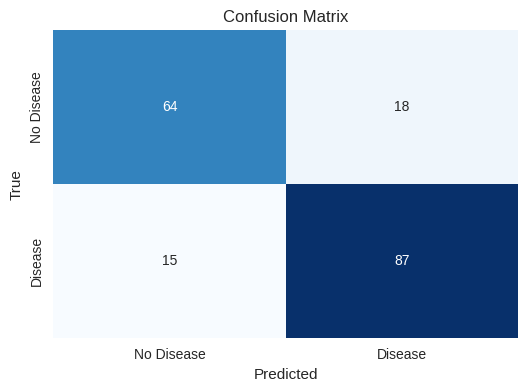

In [39]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

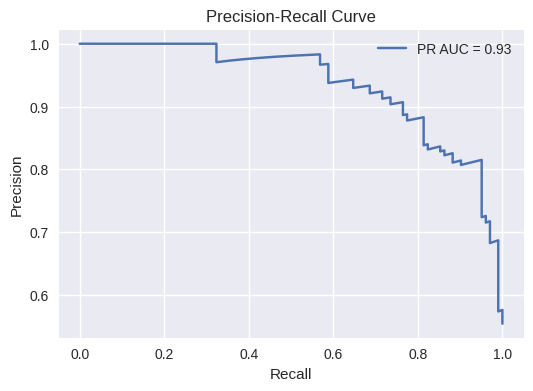

In [40]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

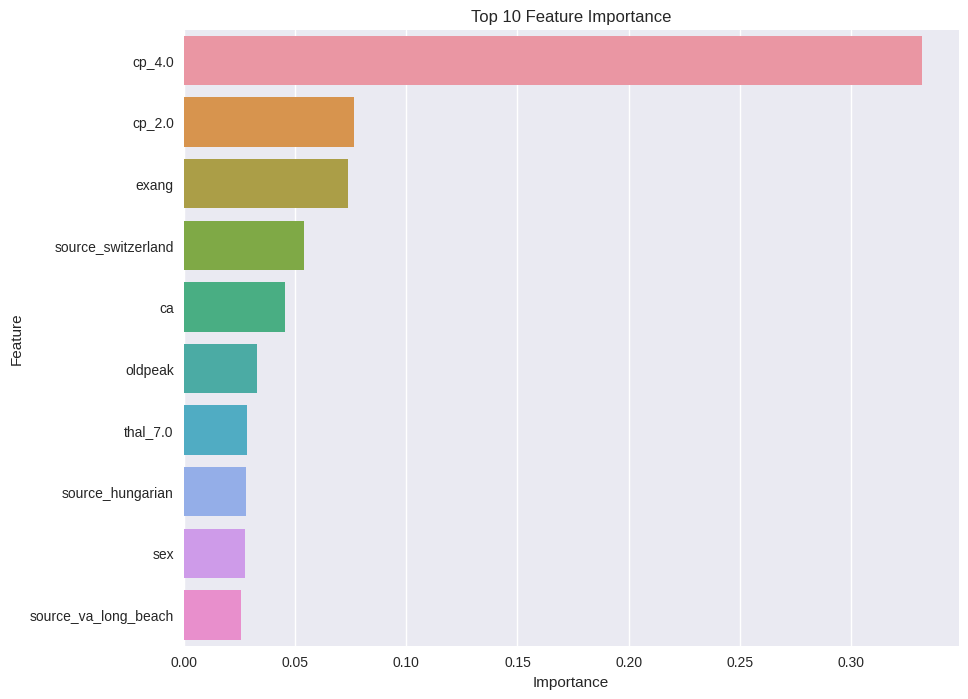

In [41]:
# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.show()

In [42]:
# Display feature importance
print("Top 10 Feature Importance:\n", feature_importance.head(10))

Top 10 Feature Importance:
                  Feature  Importance
11                cp_4.0    0.331545
9                 cp_2.0    0.076409
6                  exang    0.073956
40    source_switzerland    0.054261
8                     ca    0.045382
7                oldpeak    0.033139
38              thal_7.0    0.028659
39      source_hungarian    0.028019
1                    sex    0.027492
41  source_va_long_beach    0.025601


#### **Analysis of Results**

- The tuned XGBoost model achieved an F1 score of 0.841 and ROC-AUC of 0.916.
- High recall (0.853) ensures most disease cases are identified, critical for early intervention, though precision (0.829) indicates some false positives.
- Feature importance highlights chest pain type (cp_4.0) as the strongest predictor, followed by exercise-induced angina (exang) and dataset-specific factors (e.g., source_switzerland).
- The PR-AUC of 0.93 suggests excellent balance between precision and recall, suitable for medical decision-making.
- Recommendations: Validate the model on external datasets to assess generalizability, especially given source-related feature importance. Adjust the decision threshold (e.g., to 0.4) if higher precision is needed, at the cost of some recall.